In [1]:
%matplotlib nbagg
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import read, save

from skimage import feature
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
#from skued.image import powder_center
from matplotlib.patches import Rectangle, Circle

import h5py

In [2]:
filename='stack4D.mat'

f = h5py.File(filename, 'r')
data = np.array(f['stem4D'][:])

In [3]:
data.shape

(512, 512, 265, 262)

<IPython.core.display.Javascript object>


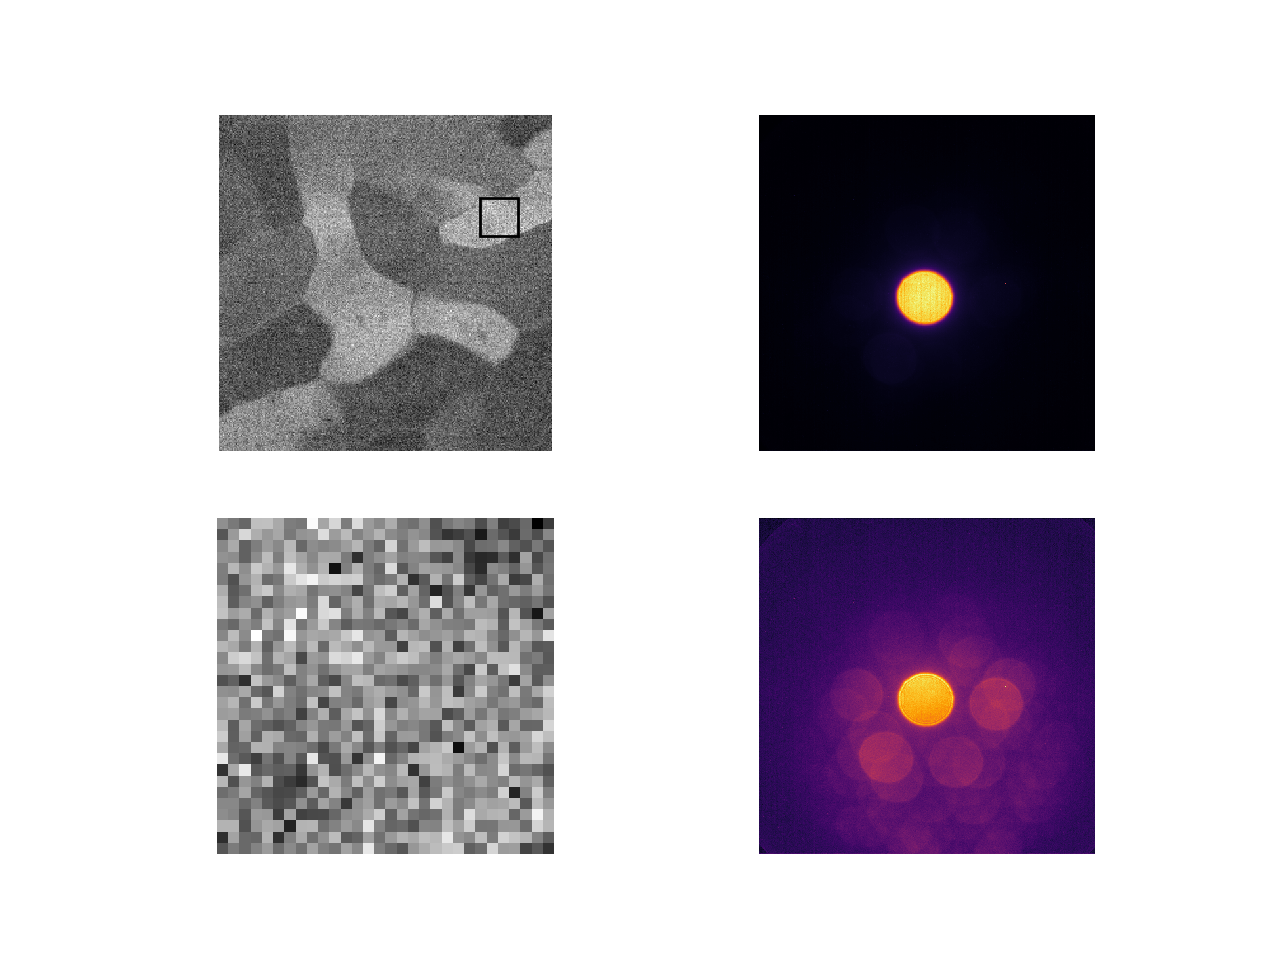

In [5]:
cropped_image = data[:,:,65:95,205:235]

aveDP = np.average(data, axis=(2,3))
realimage = np.average(data, axis=(0,1))

croppedDP=np.average(cropped_image, axis=(2,3))


fig,ax=plt.subplots(2,2)

#plot real space image
ax[0,0].matshow(realimage)
ax[0,0].add_patch(Rectangle((205, 65), 30, 30,fill=None, alpha=1))
ax[0,1].matshow(aveDP, cmap=plt.cm.inferno)
ax[1,0].matshow(np.average(cropped_image, axis=(0,1)))
ax[1,1].matshow(np.sqrt(croppedDP), cmap=plt.cm.inferno)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

plt.show()

In [6]:
filename = 'Diffraction of vacuum_256x256_50_25.dm3'
from ncempy.io import dm
vacuum = dm.dmReader(filename)

In [7]:
#normalize
vacuum_sum=np.sum(vacuum['data'])
cropped_image=cropped_image/vacuum_sum

In [8]:
#find center points of mask
blob=feature.blob_log(croppedDP, threshold = 15)
ic=blob[0,0]
jc=blob[0,1]
print(ic)
print(jc)

270.0
252.0


<IPython.core.display.Javascript object>


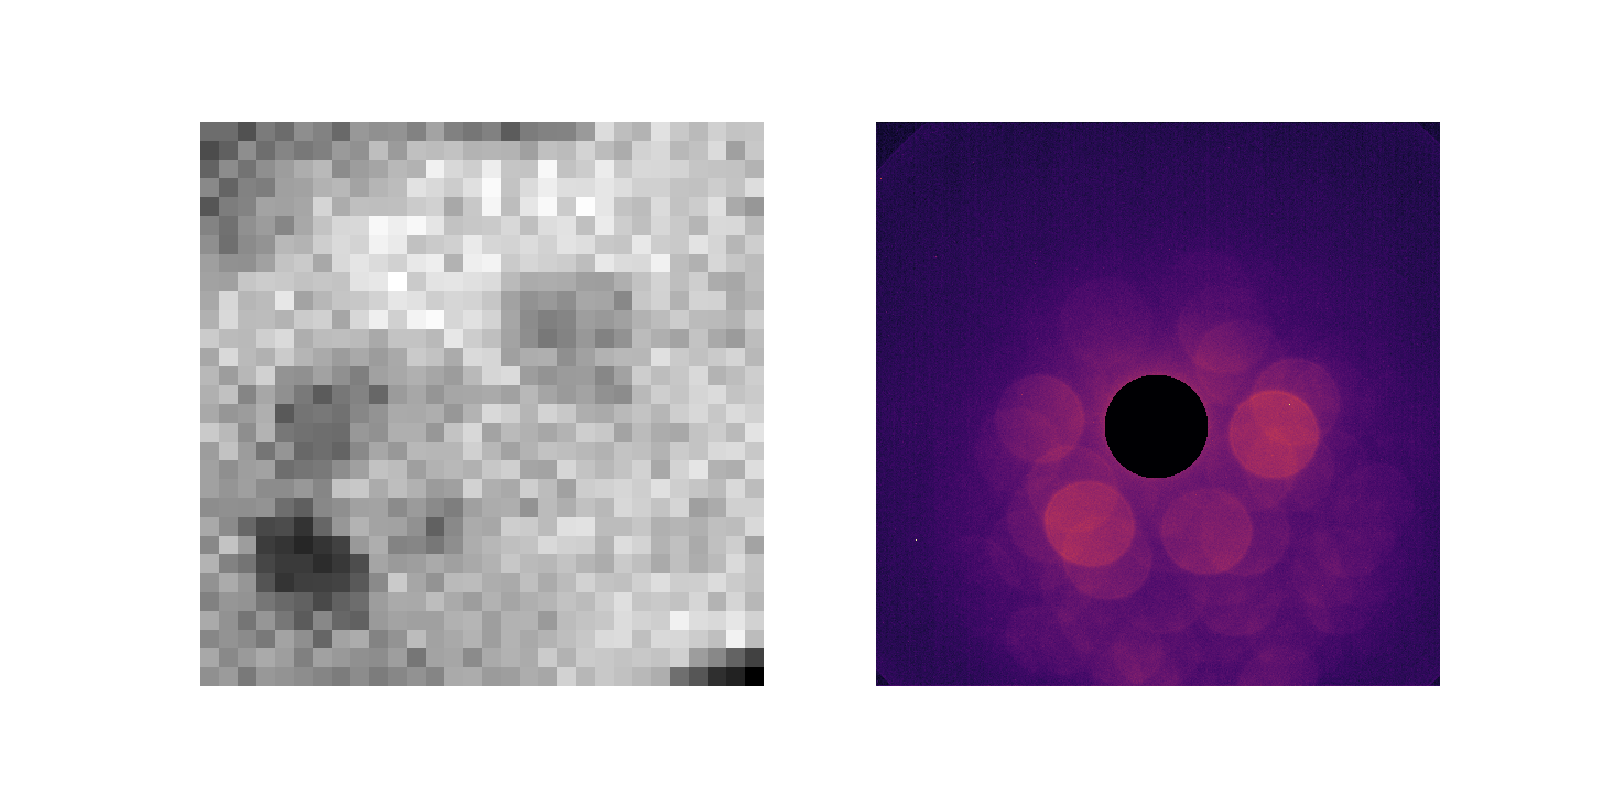

In [9]:
x, y = np.indices((croppedDP.shape[0], croppedDP.shape[1]))
ic=276
jc=254

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 47 ** 2

masked_data=cropped_image

for i in range(0,croppedDP.shape[0]):
    for j in  range(0,croppedDP.shape[1]):
        if mask_circle[i,j]: 
            masked_data[i,j,:,:]=0
masked_data_ave = np.average(masked_data, axis=(2,3))

fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].matshow(np.average(cropped_image, axis=(0,1)))
ax[1].matshow(np.sqrt(masked_data_ave), cmap=plt.cm.inferno)
ax[0].axis('off')
ax[1].axis('off')
plt.show()
        

In [10]:
def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly."""
    minimum, maximum = np.min(array), np.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [11]:
fft_stack=np.zeros([cropped_image.shape[0],cropped_image.shape[1],cropped_image.shape[2],cropped_image.shape[3]])
for i in range(cropped_image.shape[2]):
    for j in range(cropped_image.shape[3]):
            FFT=np.fft.fft2(masked_data[:,:,i,j])
            FFT=rescale_linear(FFT, -1, 1)
            fft_stack[:,:,i,j]=np.fft.fftshift(FFT)

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


<IPython.core.display.Javascript object>


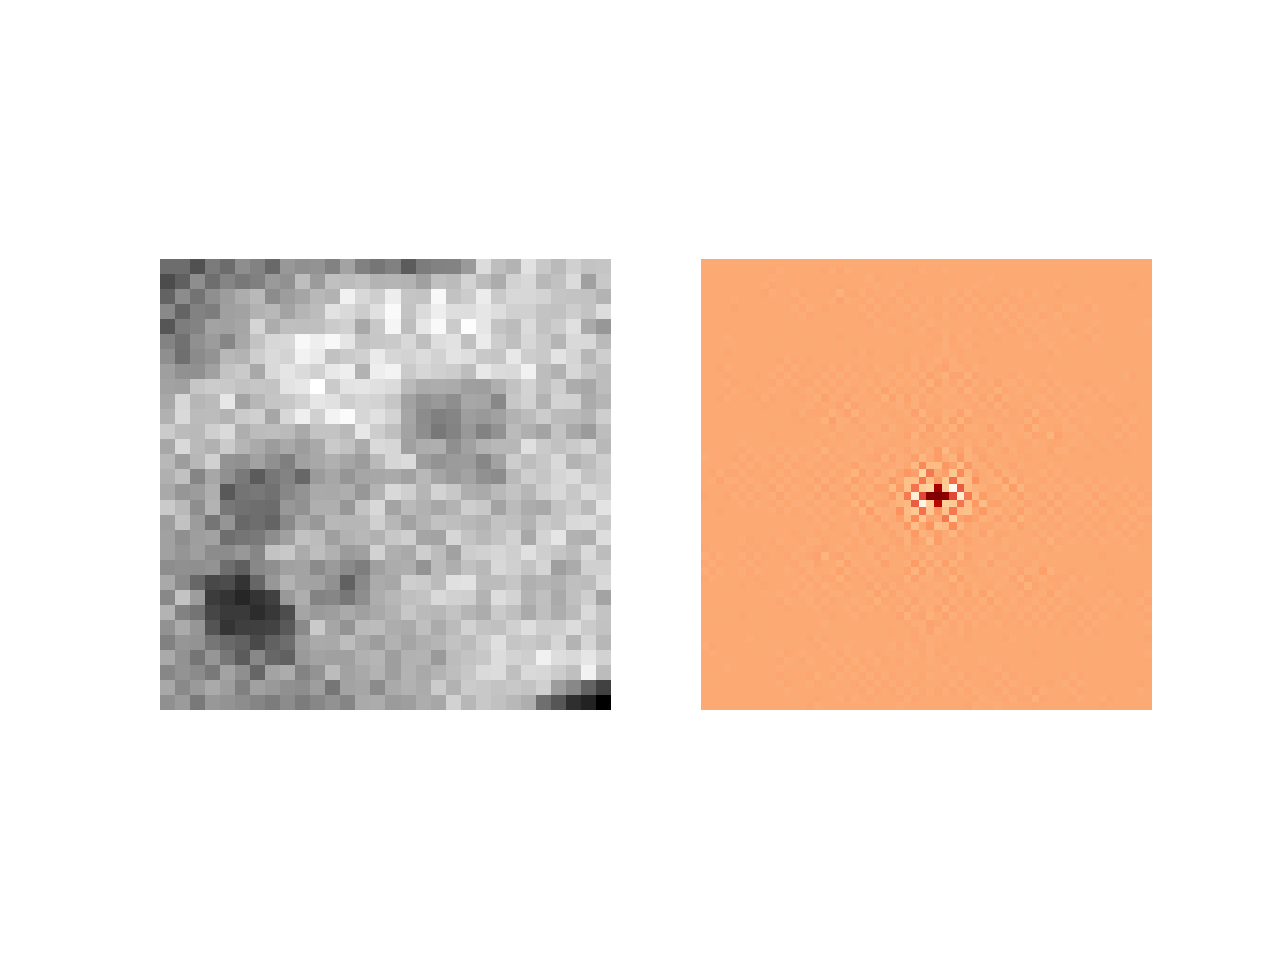

In [12]:
fig,ax=plt.subplots(1,2)

#plot real space image
ax[0].matshow(np.average(cropped_image, axis=(0,1)))
ax[1].matshow(np.log10(np.abs(np.average(fft_stack[225:285,225:285,:,:], axis=(2,3)))), cmap=plt.cm.OrRd)
#ax[1].matshow(np.log10(np.abs(fft_stack[0,0,:,:])), cmap=plt.cm.OrRd)

ax[0].axis('off')
ax[1].axis('off')

plt.show()

In [13]:
aveFFT=np.average(fft_stack, axis=(2,3))
aveFFT=rescale_linear(aveFFT, -1, 1)

s1=np.zeros([cropped_image.shape[2],cropped_image.shape[2]])
s2=np.zeros([cropped_image.shape[3],cropped_image.shape[3]])


for i in range(cropped_image.shape[2]):
    for j in range(cropped_image.shape[3]):
           s1[i,j] = ssim(fft_stack[:,:,i,j][225:285,225:285], aveFFT[225:285,225:285]) 
           s2[i,j] = mse(fft_stack[:,:,i,j][225:285,225:285], aveFFT[225:285,225:285]) 

<IPython.core.display.Javascript object>


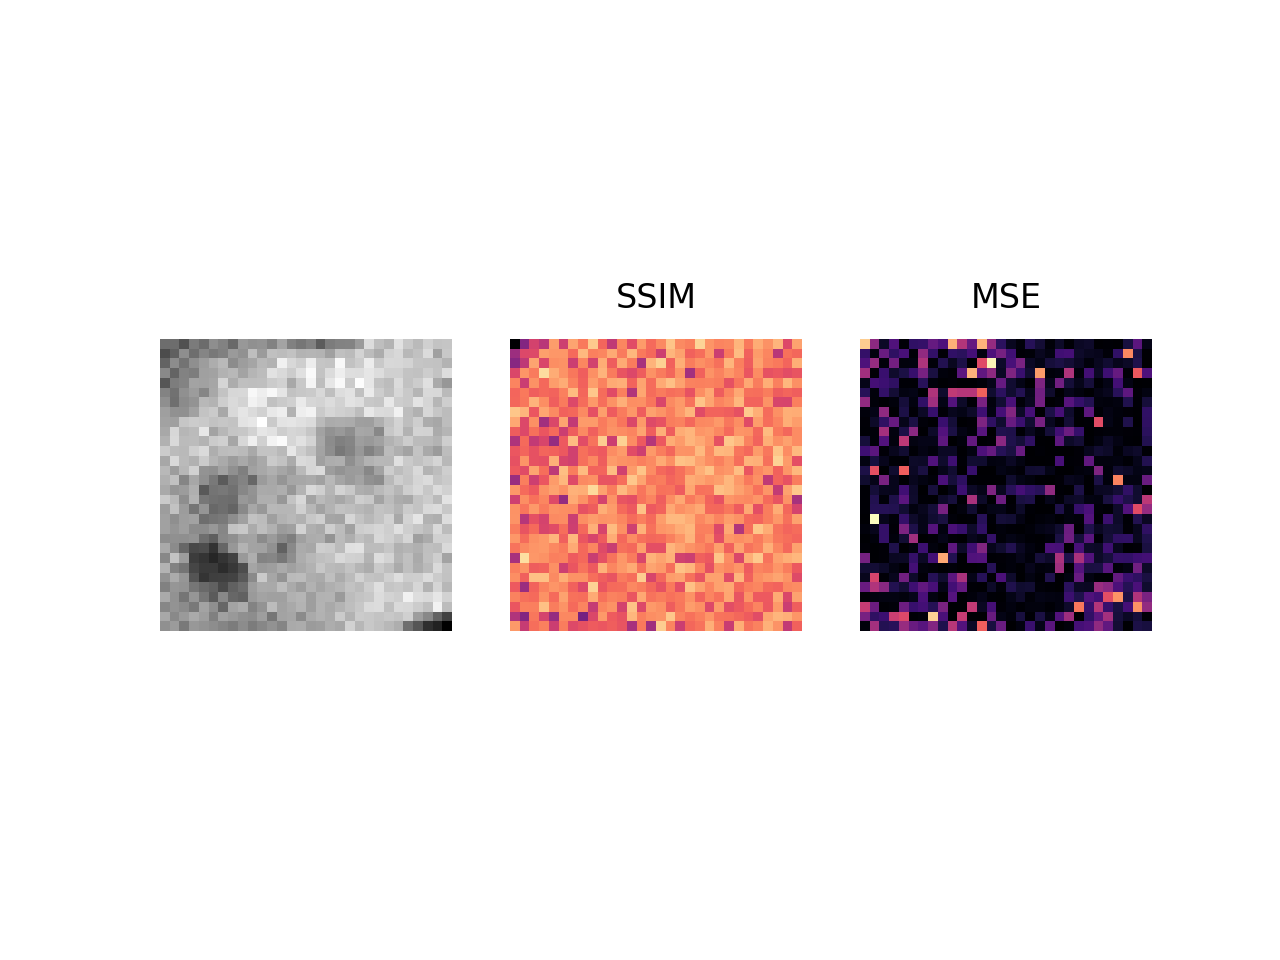

In [68]:
fig,ax=plt.subplots(1,3)

#plot real space image
ax[0].matshow(np.average(cropped_image, axis=(0,1)))
ax[1].matshow(s1, cmap=plt.cm.magma, vmax=0.97, vmin=0.93)
ax[2].matshow(s2, cmap=plt.cm.magma, vmax=0.009)
#ax[1].matshow(np.log10(np.abs(fft_stack[0,0,:,:])), cmap=plt.cm.OrRd)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[1].set_title('SSIM')
ax[2].set_title('MSE')

plt.show()

In [65]:
np.max(s2)

0.009007533207389121

<IPython.core.display.Javascript object>


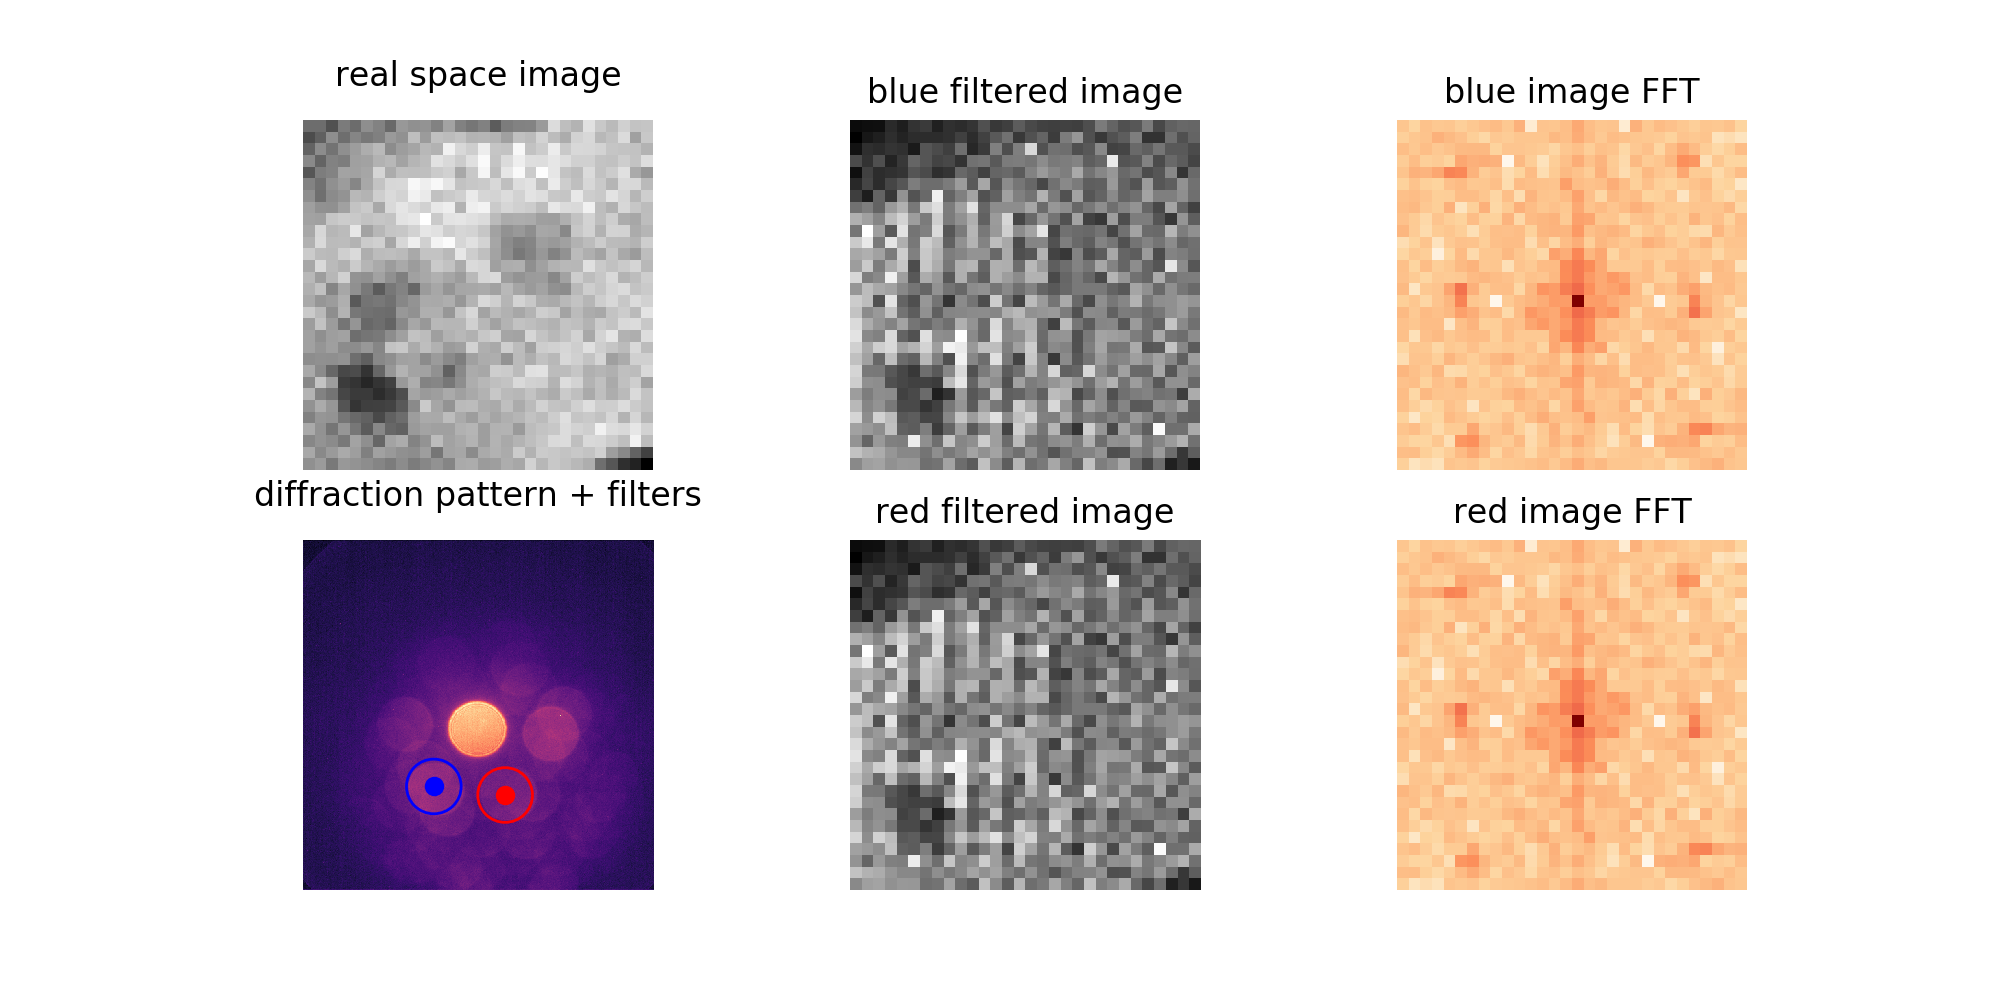

In [60]:
#masked FFT
x1,y1 = 191,360

theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

v=np.array([[x1-jc],[y1-ic]])
v=np.dot(v.T,R).T

x2=v[0,0]+jc
y2=v[1,0]+ic

#make mask
x, y = np.indices((croppedDP.shape[0], croppedDP.shape[1]))
mask_circle1 = (y - x1) ** 2 + (x - y1) ** 2 < 40 ** 2
mask_circle2 = (y - x2) ** 2 + (x - y2) ** 2 < 40 ** 2

#extract data in map 
spot1=np.zeros((cropped_image.shape[2],cropped_image.shape[3]))
spot2=np.zeros((cropped_image.shape[2],cropped_image.shape[3]))
spot1_MSE=np.zeros((cropped_image.shape[2],cropped_image.shape[3]))
spot2_MSE=np.zeros((cropped_image.shape[2],cropped_image.shape[3]))


for i in range(0,croppedDP.shape[0]):
    for j in range(0,croppedDP.shape[1]): 
        if mask_circle1[i,j]: 
            spot1=spot1+masked_data[i,j,:,:] 
            spot2=spot2+masked_data[i,j,:,:] 

            
#take fft
fft_spot1_raw_log = np.fft.fft2(np.log10(spot1))
fft_spot1_shifted_log = np.fft.fftshift(fft_spot1_raw_log)

fft_spot2_raw_log = np.fft.fft2(np.log10(spot2))
fft_spot2_shifted_log = np.fft.fftshift(fft_spot2_raw_log)



#plot
fig,ax = plt.subplots(2,3,figsize=(10,5))
ax[0,0].matshow(rescale_linear(np.average(cropped_image, axis=(0,1)),0,1))

ax[1,0].matshow(np.sqrt(croppedDP), cmap = plt.cm.magma)
ax[1,0].scatter(x1, y1, color='b')
ax[1,0].scatter(x2, y2, color='r')

circ = Circle((x1,y1),40,fill=False,color='b')
ax[1,0].add_patch(circ)

circ = Circle((x2,y2),40,fill=False,color='r')
ax[1,0].add_patch(circ)

#plot mask to check it aligns 
#ax[0,1].imshow(mask_circle2, alpha=0.3)

ax[0,1].imshow(rescale_linear(spot1,0,1))
ax[1,1].imshow(rescale_linear(spot2,0,1))

im_handle = ax[0,2].imshow(np.log10(np.abs(fft_spot1_shifted_log)), cmap=plt.cm.OrRd)

im_handle = ax[1,2].imshow(np.log10(np.abs(fft_spot2_shifted_log)), cmap=plt.cm.OrRd)

# im_handle = ax[2,0].imshow(np.log10(np.abs(fft_two_spots_raw_log)), cmap=plt.cm.OrRd)
# im_handle = ax[2,1].imshow(np.log10(np.abs(fft_image_raw_shifted_log)), cmap=plt.cm.OrRd)


ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
ax[0,2].axis('off')
ax[1,2].axis('off')

ax[0,0].set_title('real space image')
ax[1,0].set_title('diffraction pattern + filters')
ax[0,1].set_title('blue filtered image')
ax[1,1].set_title('red filtered image')
ax[0,2].set_title('blue image FFT')
ax[1,2].set_title('red image FFT')

plt.show()